In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings 
using Optim
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
using GaussianProcesses

In [4]:
include("UnivariateSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [5]:
Random.seed!(3)
xmin, xmax = -4, 4  # Bounds of the data
N = 50# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

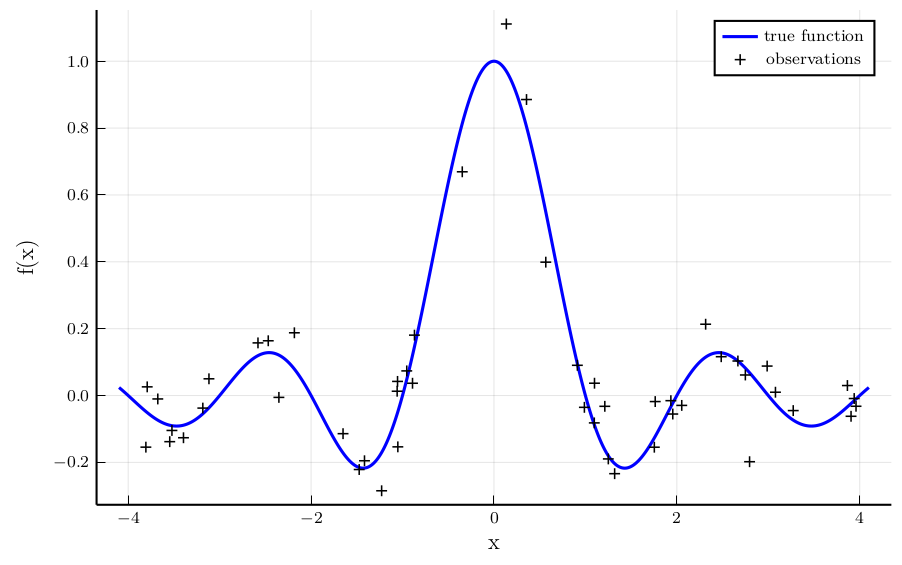

In [6]:
#Data visualization
plot(xtest,f_true,linewidth=1.5,label="true function", color =:blue)
scatter!(xtrain,ytrain, alpha=1, label="observations", ms=3.5, marker=:cross, legend=:topright)
xlabel!("x")
ylabel!("f(x)")

## Regression model

In [12]:
@model function gp_regression(y,x,Kuu)
    v ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), 100diageye(size(Kuu,1)))
    w ~ GammaShapeRate(1e-2,1e-2)

    for i=1:length(y)
        y[i] ~ GPTransition(x[i],v,w)
    end
end

gp_constraint = @constraints begin
    q(v,w) = q(v)q(w)
end 

gp_init = @initialization begin
    q(w) = GammaShapeRate(1e-2,1e-2)
end

@meta function meta_gp_regression(Xu,Kuu_inverse,kernel)
    GPTransition() -> GPTransitionMeta(nothing,Xu,Kuu_inverse,nothing,kernel,nothing)
end

meta_gp_regression (generic function with 1 method)

## Configure GP

In [82]:
Nu = 20; #number of inducing points 

Xu = range(-4,4;length=Nu);
mean_gp = (x) -> 0
kernel_gp   = 0.1*with_lengthscale(SEKernel(),0.8)
# kernel_gp   = kernel_gp_param(θ_optimal) 

Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-6*I;
Kuu_inverse = inv(Kuu) + 1e-6*I;

In [83]:
niter = 8

infer_result = infer(
    model = gp_regression(Kuu = Kuu,),
    iterations = niter,
    data = (y = ytrain, x = xtrain,),
    constraints = gp_constraint,
    initialization = gp_init,
    meta = meta_gp_regression(Xu,Kuu_inverse,kernel_gp),
    returnvars = (v = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (w, v)
  Free Energy:     | Real[35.8883, 5.62418, -11.1245, -15.5339, -15.995, -16.0199, -16.0208, -16.0208]


In [84]:
qv = infer_result.posteriors[:v]
qw = infer_result.posteriors[:w];

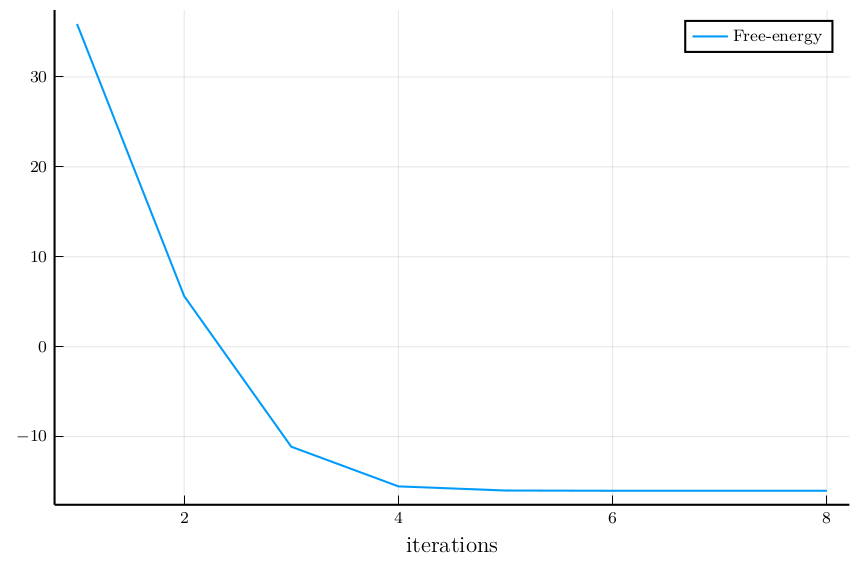

In [85]:
plot(infer_result.free_energy,label="Free-energy", legend=:topright)
xlabel!("iterations")

In [60]:
##prediction
function predict_new(x_test,qv,qw,meta)
    prediction = @call_rule GPTransition(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw, meta=meta)
    return prediction
end

predict_new (generic function with 1 method)

In [86]:
predict_mean =[]
predict_var =[]
for i=1:length(xtest)
    prediction = predict_new(xtest[i],qv,qw,GPTransitionMeta(Xu,Kuu_inverse,nothing,kernel_gp,nothing))
    append!(predict_mean,mean(prediction))
    append!(predict_var,var(prediction)) 
end

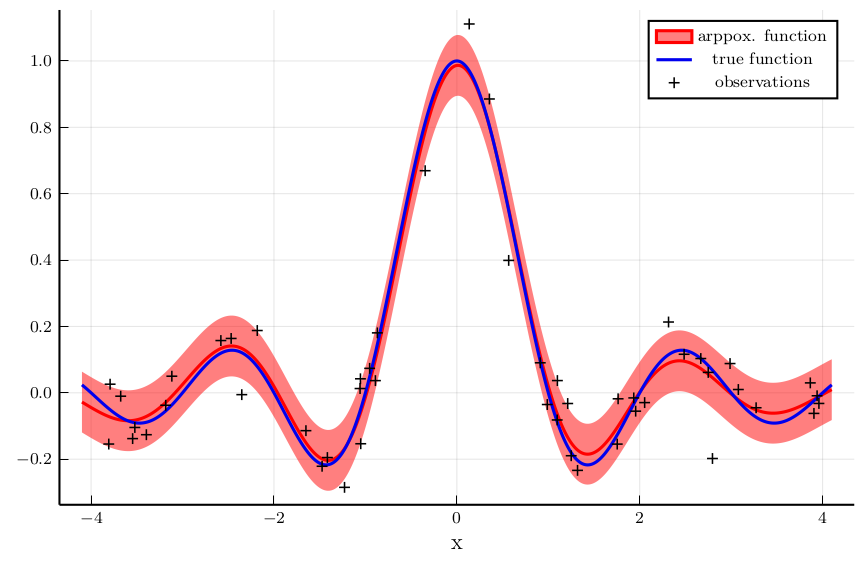

In [87]:
plot(xtest,predict_mean,ribbon = sqrt.(predict_var),
    label="arppox. function", lw=1.5,legend=:topright, color=:red1)
plot!(xtest,f_true,label="true function",lw=1.5, color=:blue2)
scatter!(xtrain,ytrain, label="observations",  alpha=1, ms=3.5, marker=:cross)
xlabel!("x")

In [85]:
savefig("texfiles/regression_result.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_result.svg"

In [88]:
Random.seed!(20140430)
# Training data
# n=10;                          #number of training points
# x = 2π * rand(n);              #predictors
# y = sin.(x) + 0.05*randn(n);   #regressors

mZero = MeanZero()                   #Zero mean function
kern = SE(log(0.1),log(0.8))                   #Sqaured exponential kernel (note that hyperparameters are on the log scale)

logObsNoise = log(1/sqrt(precision))                      # log standard deviation of observation noise (this is optional)
gp = GP(xtrain,ytrain,mZero,kern,logObsNoise) 
optimize!(gp; method=ConjugateGradient())
μ, σ² = predict_y(gp,xtest);

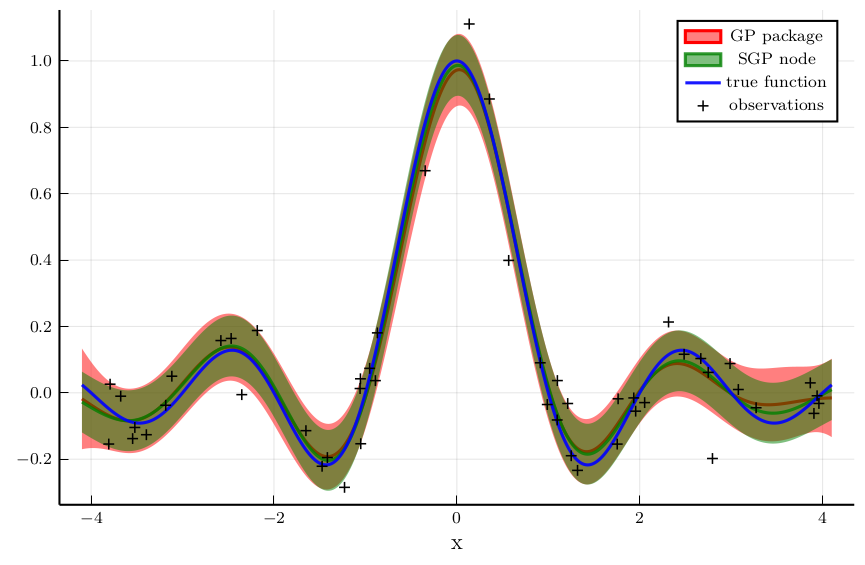

In [89]:
plot(xtest, μ, lw=1.5,ribbon = sqrt.(σ²), label="GP package", legend=:topright,color=:red1) 
plot!(xtest,predict_mean,lw=1.5, ribbon = sqrt.(predict_var),label="SGP node",color=:green,alpha=0.8)
plot!(xtest,f_true,lw=1.5, label="true function",color=:blue,alpha=0.9)
scatter!(xtrain,ytrain, label="observations",  alpha=1, ms=3.5, marker=:cross)
xlabel!("x")

In [100]:
savefig("texfiles/regression_compare.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_compare.svg"

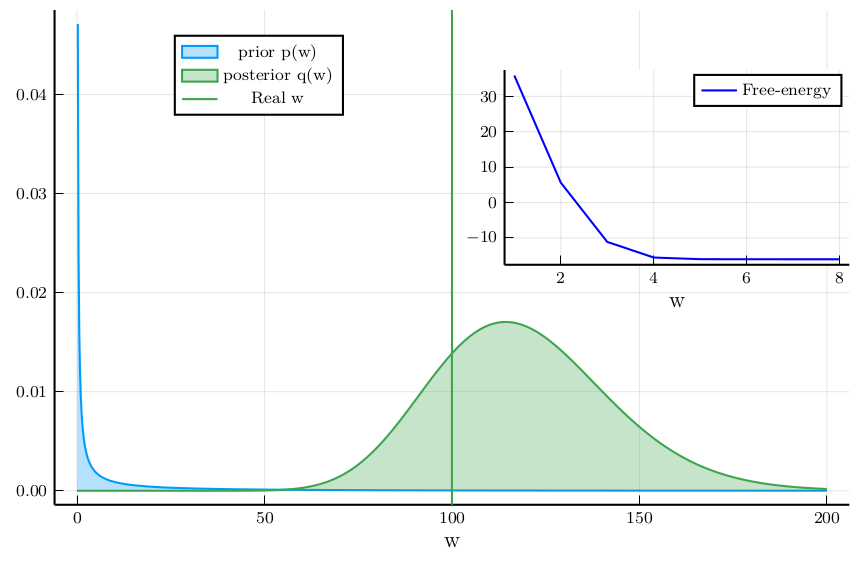

In [90]:
rw = range(0,200,length = 1000)


plot(rw, (x) -> pdf(GammaShapeRate(1e-2, 1e-2), x), fillalpha=0.3, fillrange = 0, label="prior p(w)", c=1,)
plot!(rw, (x) -> pdf(qw, x), fillalpha=0.3, fillrange = 0, label="posterior q(w)", c=3, legend_position=(0.15,0.95))

plot!(infer_result.free_energy,label="Free-energy", legend=:topright, xlabel="Iterations",
        color=:blue,
        inset = (1, bbox(0.0, 0.1, 0.5, 0.5, :top, :right)),
        subplot = 2)
vline!([precision], label="Real w")
xlabel!("w")

In [105]:
savefig("texfiles/regression_result_W.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_result_W.svg"

In [91]:
function rmse_score(y_predict, y_true)
    return sqrt(mean((y_predict - y_true).^2))
end
mse_GP_package = rmse_score(f_true, μ)
mse_node = rmse_score(f_true, predict_mean)
println("The mse of SGP node: $mse_node")
println("The mse of the GP package: $mse_GP_package")

The mse of SGP node: 0.021096010364248845
The mse of the GP package: 0.029158991431552955


## Optimize hyper-parameters

In [79]:
kernel_gp_param = (θ) -> θ[1]* with_lengthscale(SEKernel(),θ[2]); 
kernelmatrix_param = (θ) -> kernelmatrix(kernel_gp_param(θ),Xu,Xu);
function my_free_energy(θ)
    my_Kuu = kernelmatrix_param(θ)
    my_Kuu_inverse = inv(my_Kuu)
    my_kernel = kernel_gp_param(θ)
    
    infer_result = infer(
        model = gp_regression(Kuu = my_Kuu),
        iterations = 5,
        data = (y = ytrain, x = xtrain,),
        initialization = gp_init,
        constraints = gp_constraint,
        meta = meta_gp_regression(Xu,my_Kuu_inverse,my_kernel),
        free_energy = true
    )
    
    return infer_result.free_energy[end]
end

function learn_params(θ,iteration)
    lower = [0.1,0.1]
    upper = [Inf,Inf]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
    return res.minimizer
end


learn_params (generic function with 2 methods)

In [81]:
θ_init = [1.,1.]
θ_optimal = learn_params(θ_init,50)

2-element Vector{Float64}:
 0.10000025807784975
 0.8024587523213671